In [1]:
print('Name: Salih Kilicli')

Given a metric $d$ on $X=\{0,....,n\}$, consider the following semi-definite program:
\begin{equation*}
\begin{split}
\text{Minimize:} &\qquad D^2 \\
\text{Subject to:} & \qquad d^2(i,j)\le \delta_{ij}\le D^2 d^2(i,j), \qquad i,j=0,...,  n \\
	& \qquad g_{i,j}=\frac12(\delta_{0i}+\delta_{0j}-\delta_{ij}), \qquad i,j=1,...,n  \\
	& \qquad G=(g_{ij})_{i,j=1}^{n}\succeq 0. 
\end{split}
\end{equation*}
The variables are $D^2$, the $\delta_{ij}$'s, and the $g_{ij}$'s. 

## Exercise 7

For the following graphs compute the Euclidean distortion using the SDP program above and compare your experimental results to the theoretical bounds. (You could draw the graph of the function that relates the Euclidean to the number of point and compare it to the theoretical bounds.)


- $\mathsf{C}_n$ the $n$-cycle: the vertices can be indexed by $\{1,2,\dots,n\}$ and the distance is given by 
$$d_\mathsf{C}(i,j)=\min\{|i-j|,n-|i-j|\}.$$
Theoretical bounds: $c_{2}(\mathsf{C}_n)=\frac{n}{2}\sin(\frac{\pi}{n})$. The exact formula for the optimal embedding which takes values into the Euclidean plane $\ell_2^2$ is known ... and it is what you think it is but showing the optimality is not a trivial task!

- $\mathsf{H}_k$ the $k$-dimensional Hamming cube: the vertices can be indexed by $\{0,1\}^k$ and the distance is given by 
$$d_\mathsf{H}(x,y)=|\{i\colon x_i\neq y_i\}|.$$
Theoretical bounds: $c_2(\mathsf{H}_k)=\sqrt{k}=\sqrt{\log |\mathsf{H}_k|}$. The optimal embedding is given by the formal identity map from $\ell_1^k$ into $\ell_2^k$ when the Hamming cube is viewed as a subset of $\ell_1^k$. 

- $\mathsf{B}_h$ the binary tree of height $h$: the vertices can be indexed by $\cup_{k=0}^h\{0,1\}^k$ and the distance is given by 
$$d_\mathsf{B}(x,y)=|x|+|y|-2|\text{lca}(x,y)|,$$
where $|v|$ is the length of a vertex $v\in \mathsf{B}_n$ (i.e. its number of coordinates) and $lca(x,y)$ denotes the last common ancestor of $x$ and $y$.
Theoretical bounds: $c_2(\mathsf{B}_h)=\Theta(\sqrt{\log h})=\Theta(\sqrt{\log\log|\mathsf{B}_n|})$.
- $ED(\{0,1\}^d)$: the edit distance on $\{0,1\}^d$ (see the Dynamic Programming lecture for the definition and how to compute edit distances).
Theoretical bounds: $$c_2(ED(\{0,1\}^d)=\Omega(\log d)=\Omega(\log \log |ED(\{0,1\}^d)|)$$ and 
$$c_2(ED(\{0,1\}^d)=O(d)=O(\log |ED(\{0,1\}^d)|)$$
In this graph we consider only those edges that have $ED(\{0,1\}^d) = 1$.


In [2]:
import numpy as np
import cvxpy as cp

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# change matplotlib style
plt.style.use('seaborn-darkgrid')

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Solution

__NOTE:__ Using $D^2$ term in the constraint ( using any of methods: `D**2` , `cp.square(D)` or `cp.power(D, 2)` ) conflicts with __DCP Rules__ for some reason. Hence, I transformed $D^2 \rightarrow D$ and printed $\sqrt{D}$ instead.

In [3]:
from cvxpy import power, square # none of them works for D ** 2 -> D * D, power(D, 2), or square(D)
                                # I instead optimized for D = D**2 and take sqrt of the optimized result

def optimize_sdp(n, dist_func, dist_arg = None, verbose = False):
    """
    n - The number of vertices in your graph
    dist_func - A distance function to be called as 
            dist_func(i,j,dist_arg) for i,j in range(n)
    dist_arg - An additional paramter to be passed to dist_func
    verbose - Flag to be passed to solve indicating whether or not
            it should display its progress during the solve.
    Returns - (optimization status, D, G, delta)
    """
    
    D = cp.Variable(pos = True)
    delta = cp.Variable((n+1, n+1), pos = True)
    G = cp.Variable((n, n), PSD = True)

    constraints = []
    
    # Constraint 1: d_(i,j)^2 <= \delta_{i,j} <= D^2 d_(i,j)^2 for i,j = 0, ..., n (i <= j sufficient)

    for j in range(n+1):
        for i in range(j):
            constraints += [ dist_func(i, j, dist_arg)**2 <= delta[i, j] ,
                             delta[i, j] <= D * dist_func(i, j, dist_arg)**2 ]
     
    # Constraint 2: g_{i,j} = {\delta_{0,i} + \delta_{0,j} - \delta_{i,j}} for i,j = 1, ..., n 
            
    for i in range(1, n+1):
        for j in range(1, n+1):
            constraints += [ G[i-1, j-1] == (delta[0, i] + delta[0, j] - delta[i, j])/2 ]
            
    # list comprehension format
    # constraints += [G[i,j]==(delta[0,i+1]+delta[0,j+1]-delta[i+1,j+1])/2 for j in range(n) for i in range(n)]

    #constraints.append(G >> 0) does the same thing with PSD = True
    problem = cp.Problem(cp.Minimize(D), constraints)
    problem.solve(solver = cp.SCS, max_iters = 15000, verbose = False)
    return problem.status, np.sqrt(problem.value), G.value, delta.value

## Test Code

In [4]:
def plot_graph(V, E=None):
    """
    Plots the graph with edges.
    V - An np.array containing the 2D vertices of the graph.
    E - A list of edge tuples (i,j) where i and j are indices into 
            vertices.
    """
    fig = plt.figure(figsize=(10, 8))

    plt.scatter(V[:,0], V[:,1], marker='D',color='blue', s=25)

    if E is not None:
        for edge in E:
            ev_x = [V[edge[0]][0], V[edge[1]][0]]
            ev_y = [V[edge[0]][1], V[edge[1]][1]]
            plt.plot(ev_x, ev_y, color='black', zorder=-1)

    plt.show()


def plot_graph_3d(V, E=None):
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    ax.scatter(V[:,0], V[:,1], V[:,2], marker='D',color='blue', s=25)
    if E is not None:
        for edge in E:
            ev_x = [V[edge[0]][0], V[edge[1]][0]]
            ev_y = [V[edge[0]][1], V[edge[1]][1]]
            ev_z = [V[edge[0]][2], V[edge[1]][2]]
            ax.plot(ev_x, ev_y, ev_z, color='black', zorder=-1)
    plt.show()

## $n$-Cycle

$\mathsf{C}_n$ the $n$-cycle: the vertices can be indexed by $\{1,2,\dots,n\}$ and the distance is given by 
$$d_\mathsf{C}(i,j)=\min\{|i-j|,n-|i-j|\}.$$
Theoretical bounds: $c_{2}(\mathsf{C}_n)=\frac{n}{2}\sin(\frac{\pi}{n})$. The exact formula for the optimal embedding which takes values into the Euclidean plane $\ell_2^2$ is known ... and it is what you think it is but showing the optimality is not a trivial task!


In [5]:
def cycle_graph_distance(i,j,n):
    """
    i - Index of a vertex in the cycle
    j - Index of a vertex in the cycle
    n - Number of vertices in the cycle
    """
    return np.min([np.abs(i-j), n-np.abs(i-j)])

def create_cycle_graph(n):
    V = np.array([[np.cos(a),np.sin(a)] 
                  for a in np.linspace(0, 2*np.pi, n)])
    E = [(i,i+1,cycle_graph_distance(i,i+1,n)) for i in range(n-1)]
    E.append((n-1,0,cycle_graph_distance(n-1,0,n)))
    
    return V,E

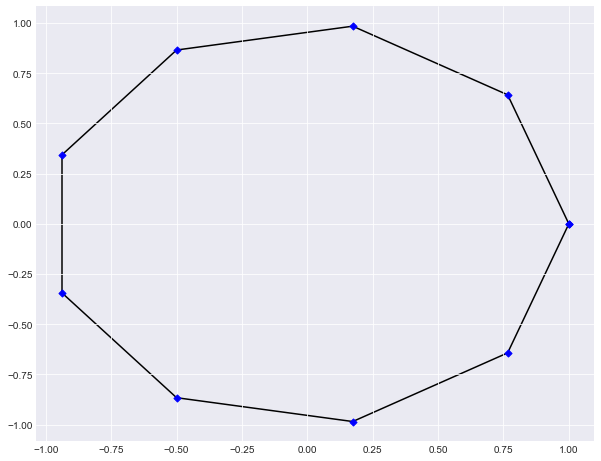

In [6]:
n = 10

V,E = create_cycle_graph(n)
plot_graph(V, E)

In [7]:
cycle_x = np.arange(5, 41, 5)
cycle_Cn = [i/2 * np.sin(np.pi / i) for i in cycle_x]
cycle_Dn = []
for i in cycle_x:
    status, D, G, delta = optimize_sdp(i, cycle_graph_distance, i)
    print(status, D)
    cycle_Dn.append(D)

optimal 1.2360831714661453
optimal 1.5452247964660168
optimal 1.4621488240218243
optimal 1.5636958047921516
optimal 1.4953742388520375
optimal 1.5592836608354608
optimal 1.516918069845115
optimal 1.5565938489744853


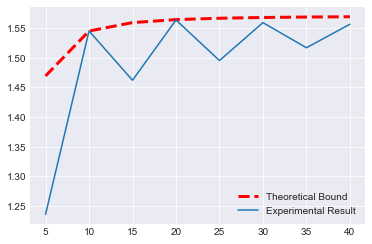

In [8]:
plt.plot(cycle_x, cycle_Cn, '--', linewidth=3, c='red', label='Theoretical Bound')
plt.plot(cycle_x, cycle_Dn, label='Experimental Result')
plt.legend()
plt.show()

## Hamming Cube

$\mathsf{H}_k$ the $k$-dimensional Hamming cube: the vertices can be indexed by $\{0,1\}^k$ and the distance is given by 
$$d_\mathsf{H}(x,y)=|\{i\colon x_i\neq y_i\}|.$$
Theoretical bounds: $c_2(\mathsf{H}_k)=\sqrt{k}=\sqrt{\log |\mathsf{H}_k|}$. The optimal embedding is given by the formal identity map from $\ell_1^k$ into $\ell_2^k$ when the Hamming cube is viewed as a subset of $\ell_1^k$. 




In [9]:
# The following two functions come from https://www.geeksforgeeks.org/check-whether-two-numbers-differ-one-bit-position/

def isPowerOfTwo(x): 
    """
    First x in the below expression is 
    for the case when x is 0 
    """
    return x and (not(x & (x - 1))) 


def differAtOneBitPos(a, b):
    """
    Function to check whether the two numbers 
    differ at one bit position only 
    """
    return isPowerOfTwo(a^b) 


def hamming_graph_distance(i,j,k):
    """
    Count the number of different bits in i and j
    i,j - Indices (and integer representation of the bit string) of vertices in the graph    
    k - The number of bits in the bit string, there are 2**k vertices in the graph
    """
    return np.sum([int(b) for b in np.binary_repr(i^j, k)])


def create_hamming_graph(k=2):
    """
    """
    V = np.array([[int(i) for i in np.binary_repr(d, k)] 
                  for d in range(2**k)])
    E = [(i,j,hamming_graph_distance(i,j,k)) 
         for i in range(2**k)
         for j in range(i+1,2**k) 
         if differAtOneBitPos(i,j)]
    return V,E


# Alternative solution
def create_hamming_graph_alt(k=2):
    """
    """
    V = np.array([[int(i) for i in np.binary_repr(d, k)] 
                  for d in range(2**k)])
    E = [(i,j,1) 
         for i in range(2**k)
         for j in range(i+1,2**k) 
         if hamming_graph_distance(i,j,k) == 1]
    return V,E

# Alternative solution 2
def create_hamming_graph_alt2(k=2):
    """
    """
    V = np.array([[int(i) for i in np.binary_repr(d, k)] 
                  for d in range(2**k)])
    E = [(i,j,1) 
         for i in range(2**k)
         for j in range(i+1,2**k) 
         if differAtOneBitPos(i,j)]
    return V,E

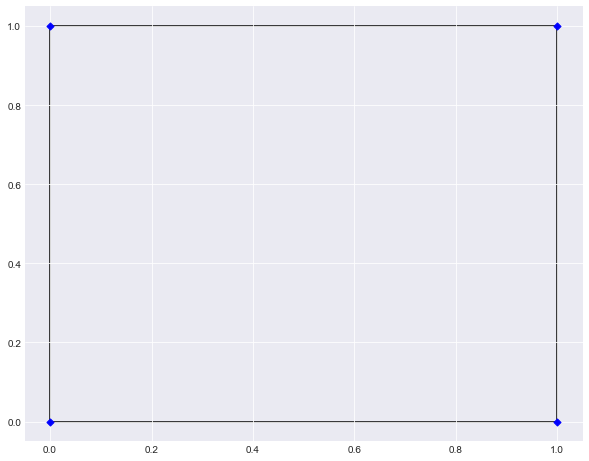

In [10]:
V,E = create_hamming_graph(2)

plot_graph(V, E)

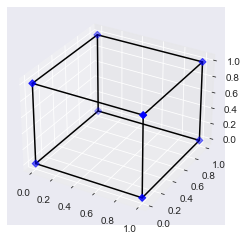

In [11]:
V,E = create_hamming_graph(3)

plot_graph_3d(V, E)

In [12]:
hamming_x = np.arange(2,7)
hamming_Cn = [np.sqrt(i) for i in hamming_x]
hamming_Dn = []
for i in hamming_x:
    status, D, G, delta = optimize_sdp(2**i, hamming_graph_distance, i)
    print(status, D)
    hamming_Dn.append(D)

optimal 1.4142139599110708
optimal 1.7320196775595194
optimal 1.9996042044652227
optimal 2.236578591945253
optimal 2.4524578416070764


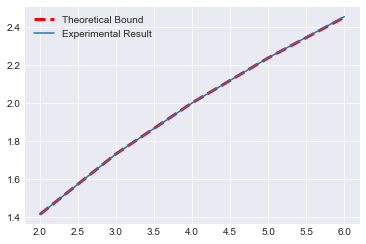

In [13]:
plt.plot(hamming_x, hamming_Cn, '--', linewidth=3, c='red', label='Theoretical Bound')
plt.plot(hamming_x, hamming_Dn, label='Experimental Result')
plt.legend()
plt.show()

## Binary Tree

$\mathsf{B}_h$ the binary tree of height $h$: the vertices can be indexed by $\cup_{k=0}^h\{0,1\}^k$ and the distance is given by 
$$d_\mathsf{B}(x,y)=|x|+|y|-2|\text{lca}(x,y)|,$$
where $|v|$ is the length of a vertex $v\in \mathsf{B}_n$ (i.e. its number of coordinates) and $lca(x,y)$ denotes the last common ancestor of $x$ and $y$.
Theoretical bounds: $c_2(\mathsf{B}_h)=\Theta(\sqrt{\log h})=\Theta(\sqrt{\log\log|\mathsf{B}_n|})$.




In [14]:
def lca(i,j):
    """
    Finds the index (1-based) of the lowest common ancestor
    i,j - Indices of the vertices in the tree (1-based indices)
    """
    while i > 0 and j > 0:
        if i == j:
            return i
        if i > j:
            i = i // 2
        else:
            j = j // 2
    return 1


def binary_tree_graph_distance(i,j,h=None):
    """
    Distance using indexes i and j 
    i,j - Indices of the vertices in the tree (0-based indices)
    """
    # convert to 1-based index for binary tree
    i_1 = i+1
    j_1 = j+1
    return (np.floor(np.log2(i_1)) 
            + np.floor(np.log2(j_1)) 
            - 2*np.floor(np.log2(lca(i_1,j_1))))
    
    
def create_binary_tree_graph(h):
    """
    """
    V = []
    for d in range(h):
        for i in range(2**d):
            x = i if d is 0 else i-2**(d-1)+0.5
            V.append([x,d])
    
    E = [] 
    for i in range(len(V)//2):
        l = 2*(i+1)-1
        r = l+1
        e1 = (i,l, binary_tree_graph_distance(i,l))
        e2 = (i,r, binary_tree_graph_distance(i,r))
        E.append(e1)
        E.append(e2)

    return np.array(V),E

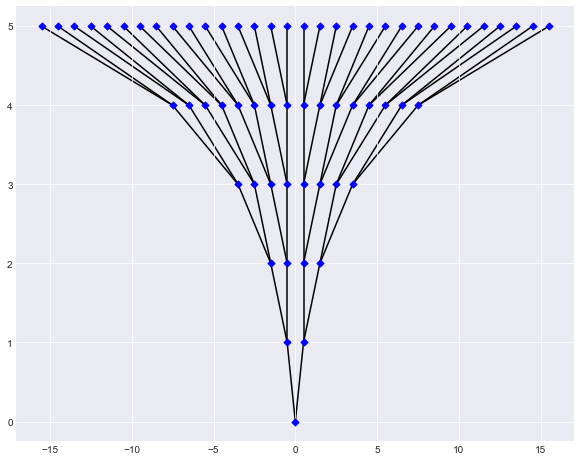

In [15]:
V,E = create_binary_tree_graph(6)

plot_graph(V, E)

In [16]:
binary_x = np.arange(2,7)
binary_Cn = [np.sqrt(np.log2(i)) for i in binary_x]
binary_Dn = []
for i in binary_x:
    status, D, G, delta = optimize_sdp(2**i-1, binary_tree_graph_distance, None)
    print(status, D)
    binary_Dn.append(D)

optimal 1.0000000221680316
optimal 1.2029334800390556
optimal 1.3480028782661417
optimal 1.4573560443548348
optimal 1.5422644147701932


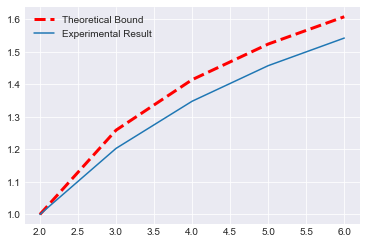

In [17]:
plt.plot(binary_x, binary_Cn, '--', linewidth=3, c='red', label='Theoretical Bound')
plt.plot(binary_x, binary_Dn, label='Experimental Result')
plt.legend()
plt.show()

## Edit Distance

$ED(\{0,1\}^d)$: the edit distance on $\{0,1\}^d$ (see the Dynamic Programming lecture for the definition and how to compute edit distances).
Theoretical bounds: $$c_2(ED(\{0,1\}^d)=\Omega(\log d)=\Omega(\log \log |ED(\{0,1\}^d)|)$$ and 
$$c_2(ED(\{0,1\}^d)=O(d)=O(\log |ED(\{0,1\}^d)|)$$
In this graph we consider only those edges that have $ED(\{0,1\}^d) = 1$.


In [18]:
def ed_graph_distance(i,j,d):
    """
    Uses the bottom-up dynamic algorithm to compute the Levenshtein metric
    i,j - Indices (and integer representation of the bit string) of vertices in the graph    
    d - The number of bits in the bit string, there are 2**d vertices in the graph
    """
    u = [int(b) for b in np.binary_repr(i, d)]
    v = [int(b) for b in np.binary_repr(j, d)]
    
    return LevDyn(u, v)


def LevDyn(x, y):
    D = [[0 for j in range(len(y)+1)] for i in range(len(x)+1)]
    
    for i in range(1,len(x)+1):
        D[i][0] = i
    for j in range(1,len(y)+1):
        D[0][j] = j
    for i in range(1,len(x)+1):
        for j in range(1,len(y)+1):
            if x[i-1] == y[j-1]:
                c = 0
            else:
                c = 1
            D[i][j] = min(D[i-1][j]+1, D[i][j-1]+1, D[i-1][j-1]+c)
    return D[len(x)][len(y)]


def create_ed_graph(d):
    """
    """
    V = np.array([[int(i) for i in np.binary_repr(b, d)] 
                  for b in range(2**d)])
    E = [(i,j,1)  
         for i in range(2**d)
         for j in range(i+1,2**d) 
         if ed_graph_distance(i,j,d) == 1]
    return V,E

In [19]:
V,E = create_ed_graph(6)

In [20]:
ed_x = np.arange(2,7)
ed_Cn_Omega = [np.log2(i) for i in ed_x]
ed_Cn_O = [i for i in ed_x] # ed_x
ed_Dn = []
for i in ed_x:
    status, D, G, delta = optimize_sdp(2**i, ed_graph_distance, i)
    print(status, D)
    ed_Dn.append(D)

optimal 1.4142109718118983
optimal 1.612432788000627
optimal 1.7605332633122104
optimal 1.909739666564648
optimal 2.0360111514362798


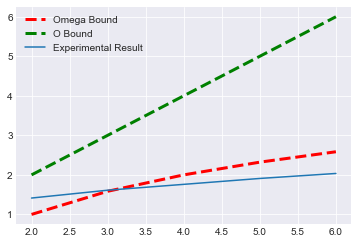

In [21]:
plt.plot(ed_x, ed_Cn_Omega, '--', linewidth=3, c='red', label='Omega Bound')
plt.plot(ed_x, ed_Cn_O, '--', linewidth=3, c='green', label='O Bound')
plt.plot(ed_x, ed_Dn, label='Experimental Result')
plt.legend()
plt.show()